In [199]:
import pandas as pd
import seaborn as sns
import scipy
from scipy.stats import chi2_contingency
from sklearn import tree
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [172]:
# define cols to load
part = 100000
selected_cols = ['TFS_Arrival_Time', 'Possible_Cause', 'Property_Use', 
                 'Fire_Alarm_System_Presence', 'Incident_Station_Area',
                'Material_First_Ignited', 'Area_of_Origin']

# load dataset, remove NaN
ds = pd.read_csv('data/Fire-Incidents.csv', usecols=selected_cols)
ds = ds.dropna()
ds = ds[0:part]

In [173]:
print('Before processing')
print(len(ds))
ds[0:5]

Before processing
11214


,Area_of_Origin,Fire_Alarm_System_Presence,Incident_Station_Area,Material_First_Ignited,Possible_Cause,Property_Use,TFS_Arrival_Time
0,Porch or Balcony,Fire alarm system present,114,Undetermined (formerly 98),Undetermined,Multi-Unit Dwelling - Over 12 Units,2018-08-24T16:54:09
1,Cooking Area or Kitchen,Fire alarm system present,142,Plastic,Under Investigation,Infirmary,2018-11-24T07:14:23
2,"Living Area (e.g. living, TV, recreation, etc)",Fire alarm system present,325,Undetermined (formerly 98),Undetermined,Multi-Unit Dwelling - Over 12 Units,2017-02-09T17:48:49
3,Undetermined (formerly 98),Undetermined,332,Undetermined (formerly 98),Undetermined,"Clothing Store, Accessories, fur",2012-10-30T00:44:58
4,"Sleeping Area or Bedroom (inc. patients room, ...",Fire alarm system present,442,Bedding,Suspected Arson,Multi-Unit Dwelling - Over 12 Units,2018-07-08T04:13:54


In [174]:
print('Fire_Alarm_System_Presence', ds['Fire_Alarm_System_Presence'].unique())
print('======')
print('Possible_Cause', ds['Area_of_Origin'].unique())
print('======')
print('Property_Use', ds['Property_Use'].unique())

Fire_Alarm_System_Presence ['Fire alarm system present' 'Undetermined' 'No Fire alarm system'
 'Not applicable (bldg not classified by OBC OR detached/semi/town home)']
Possible_Cause ['Porch or Balcony' 'Cooking Area or Kitchen'
 'Living Area (e.g. living, TV, recreation, etc)'
 'Undetermined  (formerly 98)'
 'Sleeping Area or Bedroom (inc. patients room, dormitory, etc)'
 'Engine Area' 'Concealed Ceiling Area' 'Hallway, Corridor' 'Laundry Area'
 'Roof' 'Electrical Systems' 'Storage Area (outside)'
 'Basement/cellar (not partitioned)' 'Court, Patio, Terrace'
 'Lobby, Entranceway'
 'Trash, Rubbish Storage (inc garbage chute room, garbage/industri'
 'Other Outside Area' 'Closet (eg. clothes, broom, linen closet, etc.)'
 'Garage' 'Trash, rubbish area (outside)'
 'Dining or Beverage Area (inc mess, canteen, lunchroom, cafeteria'
 'Washroom or Bathroom (toilet,restroom/locker room)' 'Attached Deck'
 'Other - unclassified' 'Mechanical/Electrical Services Room'
 'Other Storage Area' 'Stairwa

In [175]:
ds['TFS_Arrival_Time'] = ds['TFS_Arrival_Time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S').strftime('%-m'))
ds['TFS_Arrival_Time'] = ds['TFS_Arrival_Time'].astype('int')
for col in selected_cols[1:len(selected_cols)]:
    unique_col = ds[col].unique()
    for date in unique_col:
        ds[col] = ds[col].replace(date, np.where(unique_col == date)[0][0])
ds.to_csv('toronto.csv', index=False)

In [176]:
print('After processing')
print(len(ds))
ds[:5]

After processing
11214


,Area_of_Origin,Fire_Alarm_System_Presence,Incident_Station_Area,Material_First_Ignited,Possible_Cause,Property_Use,TFS_Arrival_Time
0,0,0,0,0,0,0,8
1,1,0,1,1,1,1,11
2,2,0,2,0,0,0,2
3,3,1,3,0,0,2,10
4,4,0,4,2,2,0,7


<AxesSubplot:>

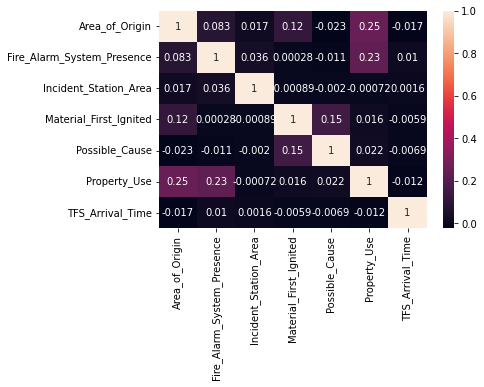

In [206]:
# pandas correlation, may not be suitable for categorical
corr = ds.corr(method='kendall', min_periods=1)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

In [203]:
# chi square correlation, suitable for categorical
# source: https://www.youtube.com/watch?v=_jdfjRzaHMM
tips_categorical=ds[['TFS_Arrival_Time', 'Possible_Cause', 'Property_Use', 
                 'Fire_Alarm_System_Presence', 'Incident_Station_Area',
                'Material_First_Ignited', 'Area_of_Origin']]

def cramers_V(var1,var2):
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

rows= []

for var1 in tips_categorical:
  col = []
  for var2 in tips_categorical :
    cramers =cramers_V(tips_categorical[var1], tips_categorical[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = tips_categorical.columns, index =tips_categorical.columns)

In [204]:
df

,TFS_Arrival_Time,Possible_Cause,Property_Use,Fire_Alarm_System_Presence,Incident_Station_Area,Material_First_Ignited,Area_of_Origin
TFS_Arrival_Time,1.00,0.00,0.02,0.00,0.01,0.01,0.01
Possible_Cause,0.00,1.00,0.03,0.01,0.01,0.07,0.07
Property_Use,0.02,0.03,1.00,0.21,0.04,0.03,0.07
Fire_Alarm_System_Presence,0.00,0.01,0.21,1.00,0.05,0.03,0.06
Incident_Station_Area,0.01,0.01,0.04,0.05,1.00,0.01,0.01
Material_First_Ignited,0.01,0.07,0.03,0.03,0.01,1.00,0.08
Area_of_Origin,0.01,0.07,0.07,0.06,0.01,0.08,1.00


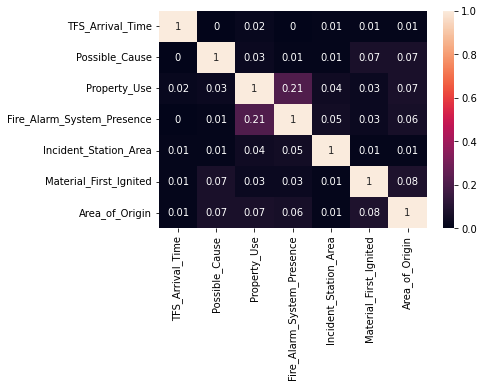

In [205]:

# generating 2-D 10x10 matrix of random numbers
# from 1 to 100
data = np.random.randint(low=1,
                         high=100,
                         size=(10, 10))
  
# setting the parameter values
annot = True
  
# plotting the heatmap
hm = sns.heatmap(data=df,
                annot=annot)
  
# displaying the plotted heatmap
plt.show()